<a href="https://colab.research.google.com/github/ilyandho/FPL-Optimal-Transfer/blob/main/FPL_points_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (12,9)

# Data collection

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fpl_player_data.csv').drop(columns=['Unnamed: 0'])

In [6]:
# Separate the week to be predicted
##
def get_details(gw):
    # player_data = pd.DataFrame(get_player_data(gw))

    # Separate next gw's data
    next_gw_data = df[df['gw'] == gw]

    # Drop this data from the rest of data
    player_data = df.drop(df[df['gw'] >= gw].index)

    return player_data #, next_gw_data


details = get_details(39)
details.head()

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
4,5,1,2,5,2,4,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1,False


In [7]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29679 entries, 0 to 29678
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29679 non-null  int64  
 1   gw                          29679 non-null  int64  
 2   team_h_difficulty           29679 non-null  int64  
 3   team_a_difficulty           29679 non-null  int64  
 4   position                    29679 non-null  int64  
 5   minutes                     29679 non-null  int64  
 6   goals_scored                29679 non-null  int64  
 7   assists                     29679 non-null  int64  
 8   clean_sheets                29679 non-null  int64  
 9   goals_conceded              29679 non-null  int64  
 10  own_goals                   29679 non-null  int64  
 11  penalties_saved             29679 non-null  int64  
 12  penalties_missed            29679 non-null  int64  
 13  yellow_cards                296

#Data pre-processing

In [36]:
player_data = details.copy()
# next_gw_data = details[1]
# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id','gw','team_h_difficulty', 'team_a_difficulty', 'position', 'minutes',  'goals_scored',
              'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
              'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
              'threat', 'ict_index', 'starts','expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
player_data = player_data[attributes]
player_data

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
4,5,1,2,5,2,4,0,0,0,0,...,0.2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29674,862,38,3,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29675,863,38,2,5,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29676,864,38,3,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29677,865,38,3,3,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0


In [37]:
def prev_3(feats, data): # create a feature that data in last 3 gws
  data = data.copy()
  data = data.sort_values(by=['id', 'gw'])  # Sort by ID and gameweek
  for feat in feats:
    data[feat+'_3'] = (
        data.groupby(['id'])[feat]
        .rolling(3, min_periods=1, closed='left').sum()).reset_index(level=0, drop=True).fillna(data[feat])
  return data

In [38]:
feats = ['starts','minutes',  'goals_scored',  'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
        'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity','threat']

y = prev_3(feats, player_data)
player_data_3 = y.drop(feats, axis=1)
player_data_3


,id,gw,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
0,1,1,2,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,1,2,5,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1328,1,3,2,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,1,4,3,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2716,1,5,5,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29674,862,38,3,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29675,863,38,2,5,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29676,864,38,3,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29677,865,38,3,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
working_data = player_data_3.loc[player_data_3['gw'] < 29]
working_data = working_data.drop(['id','gw'], axis=1)

working_data

,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,starts_3,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
0,2,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,5,3,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1328,2,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,3,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2716,5,3,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21153,2,3,1,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21154,2,2,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21155,5,5,2,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21156,3,4,2,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Split data by positions
df_gk = working_data.loc[working_data['position'] == 1].drop('position', axis='columns')
print(df_gk.shape)

df_def = working_data.loc[working_data['position'] == 2].drop('position', axis='columns')
print(df_def.shape)

df_mid = working_data.loc[working_data['position'] == 3].drop('position', axis='columns')
print(df_mid.shape)

df_for = working_data.loc[working_data['position'] == 4].drop('position', axis='columns')
print(df_for.shape)

(2439, 25)
(6848, 25)
(9139, 25)
(2732, 25)


# Feature engineering

## Goalkeepers


In [43]:
# isolate the target variable
gk_target = df_gk['total_points']
gk_feature = df_gk.drop('total_points', axis=1)

# scale the data
scaler = StandardScaler().set_output(transform="pandas")
gk_scaled_data = scaler.fit_transform(gk_feature)


gk_train, gk_test, gk_tar_train, gk_tar_test = train_test_split(gk_scaled_data, gk_target, test_size=0.2)


## Baseline Model

### Linear Model

In [64]:
from sklearn.linear_model import LinearRegression
base_LR_model = LinearRegression()

base_LR_model.fit(gk_train, gk_tar_train)

base_LR_preds = base_LR_model.predict(gk_test)

base_LR_model.score(gk_test, gk_tar_test)


# mean_squared_error, root_mean_squared_error mean_absolute_error
mse = mean_squared_error(gk_tar_test, base_LR_preds)
rmse = mean_squared_error(gk_tar_test, base_LR_preds, squared=False)
mae = mean_absolute_error(gk_tar_test, base_LR_preds)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 2.3567338533003983e+23
Root Mean Squared Error: 485462032840.9214
Mean Absolute Error: 21975833659.790268


### Random Forest

In [44]:
base_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

base_rf_model.fit(gk_train, gk_tar_train)

base_preds = base_rf_model.predict(gk_test)

base_rf_model.score(gk_test, gk_tar_test)

#mean_squared_error, mean_absolute_error
mse = mean_squared_error(gk_tar_test, base_preds)
rmse =mean_squared_error(gk_tar_test, base_preds, squared=False)
mae = mean_absolute_error(gk_tar_test, base_preds)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 1.539231161975234
Root Mean Squared Error: 1.24065755225817
Mean Absolute Error: 0.4546473505816806


<Axes: >

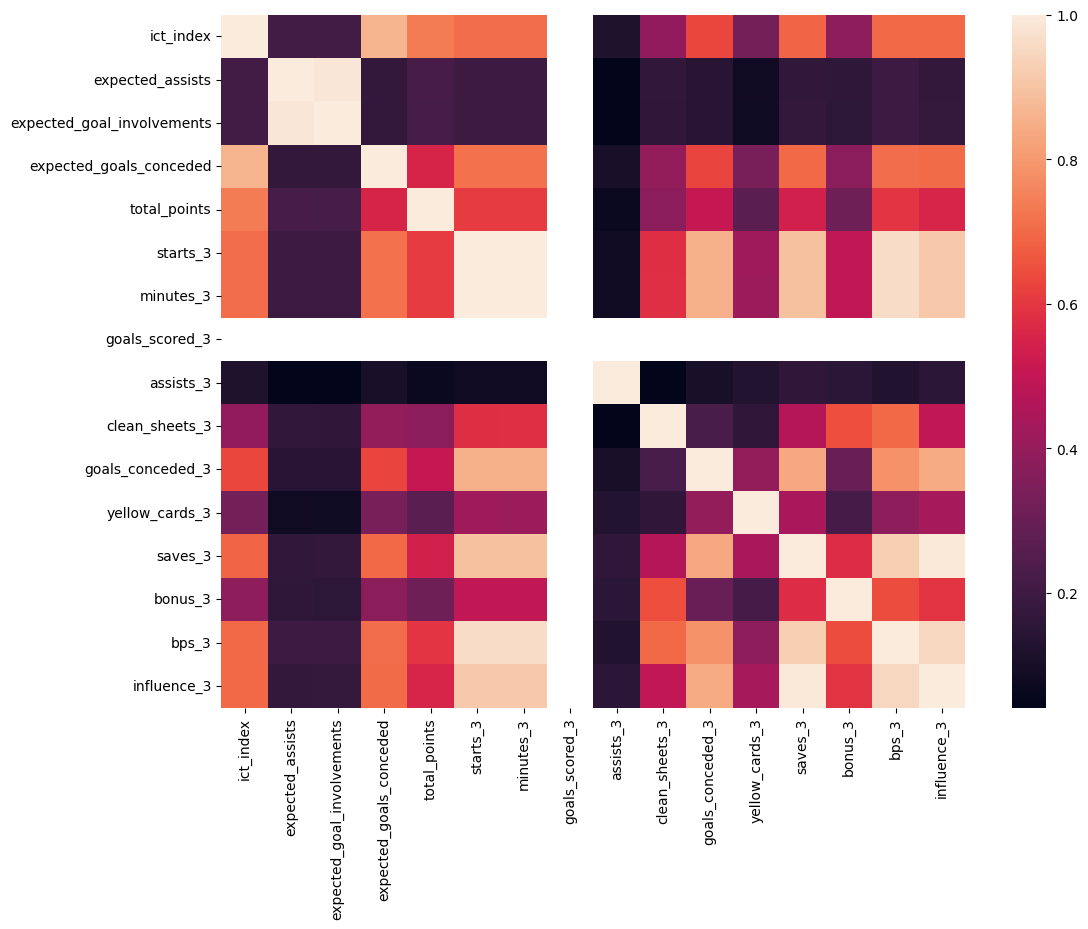

In [16]:
# remove uncorelated features
df_gk_corr = df_gk.drop(['team_h_difficulty','team_a_difficulty','threat_3','creativity_3','red_cards_3','penalties_missed_3','penalties_saved_3','own_goals_3', 'expected_goals'], axis=1)
sns.heatmap(df_gk_corr.corr())

In [17]:
base_rf_model_updated = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

base_rf_model_updated.fit(gk_train, gk_tar_train)

base_preds = base_rf_model_updated.predict(gk_test)

base_rf_model_updated.score(gk_test, gk_tar_test)

#mean_squared_error, mean_absolute_error
mse = mean_squared_error(gk_tar_test, base_preds)
rmse =mean_squared_error(gk_tar_test, base_preds, squared=False)
mae = mean_absolute_error(gk_tar_test, base_preds)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 1.8845538615816593
Root Mean Squared Error: 1.3727905381308756
Mean Absolute Error: 0.5105382863861258


In [18]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(gk_scaled_data)

# # Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
# X_pca = pd.DataFrame(X_pca, columns=component_names)

# X_pca.head()

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=gk_scaled_data.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
team_h_difficulty,-2.545041e-03,7.063575e-03,2.128650e-01,-3.053356e-01,5.452364e-01,7.956164e-02,3.028102e-02,-2.814542e-01,2.353625e-01,-6.381183e-01,...,6.470960e-03,2.247371e-03,6.626256e-03,-1.916721e-03,2.647579e-04,7.596170e-05,-7.358662e-17,1.349356e-18,9.917797e-19,-7.906910e-19
team_a_difficulty,-3.493426e-04,1.183048e-03,2.400940e-01,-2.932891e-01,5.311213e-01,-2.389527e-01,-8.776446e-02,-1.158837e-01,-3.007570e-01,6.077974e-01,...,-2.723807e-03,-8.024438e-03,1.218847e-02,-3.224300e-03,-7.383671e-04,-8.600096e-05,8.196194e-16,-2.652895e-17,3.521400e-17,-4.279326e-17
ict_index,2.825782e-01,-2.357589e-03,-9.470520e-02,-4.387238e-02,1.285700e-01,-3.681643e-02,-2.861499e-02,2.516923e-04,-2.052613e-01,-4.387944e-02,...,4.705208e-01,-5.231804e-01,-2.369171e-02,-6.011574e-03,2.136804e-03,-2.412442e-04,-4.232456e-16,9.892201e-17,-1.464126e-16,1.508478e-16
expected_goals,9.773147e-03,9.945051e-02,-8.007272e-02,-1.458804e-01,3.100979e-01,1.622803e-01,4.139936e-01,7.754224e-01,2.059559e-01,7.223217e-02,...,1.307623e-02,1.602741e-02,1.391194e-02,1.554147e-03,2.629204e-03,2.994233e-04,-1.108591e-01,1.450770e-03,8.398907e-04,-4.776851e-04
expected_assists,9.803298e-02,6.715162e-01,-8.588715e-02,-2.594978e-02,-4.883163e-02,7.093956e-02,-5.267411e-02,-1.472359e-01,-5.619952e-02,1.224030e-02,...,-1.866955e-02,8.086380e-03,1.978999e-03,3.019387e-03,4.496446e-04,9.470452e-04,-6.984094e-01,9.139815e-03,5.291292e-03,-3.009405e-03
expected_goal_involvements,9.839016e-02,6.790606e-01,-9.741487e-02,-4.851666e-02,3.857562e-04,9.553892e-02,1.288304e-02,-2.386290e-02,-2.322610e-02,2.342151e-02,...,-1.639497e-02,1.050295e-02,4.137043e-03,3.226914e-03,8.565842e-04,9.826469e-04,7.068857e-01,-9.250741e-03,-5.355510e-03,3.045929e-03
expected_goals_conceded,2.830934e-01,-3.354408e-02,-8.871557e-02,-5.007940e-02,1.253089e-01,-6.409819e-02,-2.801905e-02,1.902643e-03,-2.144006e-01,-5.658177e-02,...,-4.407385e-01,5.528485e-01,5.897295e-02,1.008214e-02,-2.115493e-03,9.680974e-04,-1.066850e-16,-9.618087e-18,-1.402204e-17,-1.741847e-16
starts_3,3.411260e-01,-5.779242e-02,-6.668896e-02,-6.974866e-02,-2.693753e-02,-4.708979e-02,1.139258e-02,8.923283e-03,-5.824205e-03,-3.153188e-02,...,1.570837e-01,1.633986e-01,-4.417961e-01,-2.377265e-01,-1.617171e-01,6.738591e-01,-1.994022e-15,-2.252443e-16,6.823927e-17,-2.895286e-16
minutes_3,3.417869e-01,-5.639548e-02,-6.510045e-02,-7.046608e-02,-2.822076e-02,-4.796043e-02,1.141212e-02,9.055016e-03,-3.772326e-03,-3.089288e-02,...,1.506098e-01,1.562050e-01,-4.189337e-01,-1.149052e-01,-1.047562e-01,-7.336263e-01,1.367687e-15,1.360129e-17,3.758089e-17,2.665742e-16
goals_scored_3,-0.000000e+00,-8.673617e-19,-2.775558e-17,-5.551115e-17,-5.551115e-17,-8.326673e-17,1.249001e-16,-8.500145e-17,0.000000e+00,-1.387779e-17,...,-2.220446e-16,1.665335e-16,9.714451e-17,-3.330669e-16,4.857226e-16,1.630640e-16,-1.450322e-02,-5.876579e-01,-5.763800e-01,5.676565e-01


<ipython-input-20-788faecd508c>:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_gk.penalties_missed_3, fill=True, ax=axs[2,0])
<ipython-input-20-788faecd508c>:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_gk.red_cards_3, fill=True, ax=axs[2,2])


<Axes: xlabel='expected_goals_conceded', ylabel='Density'>

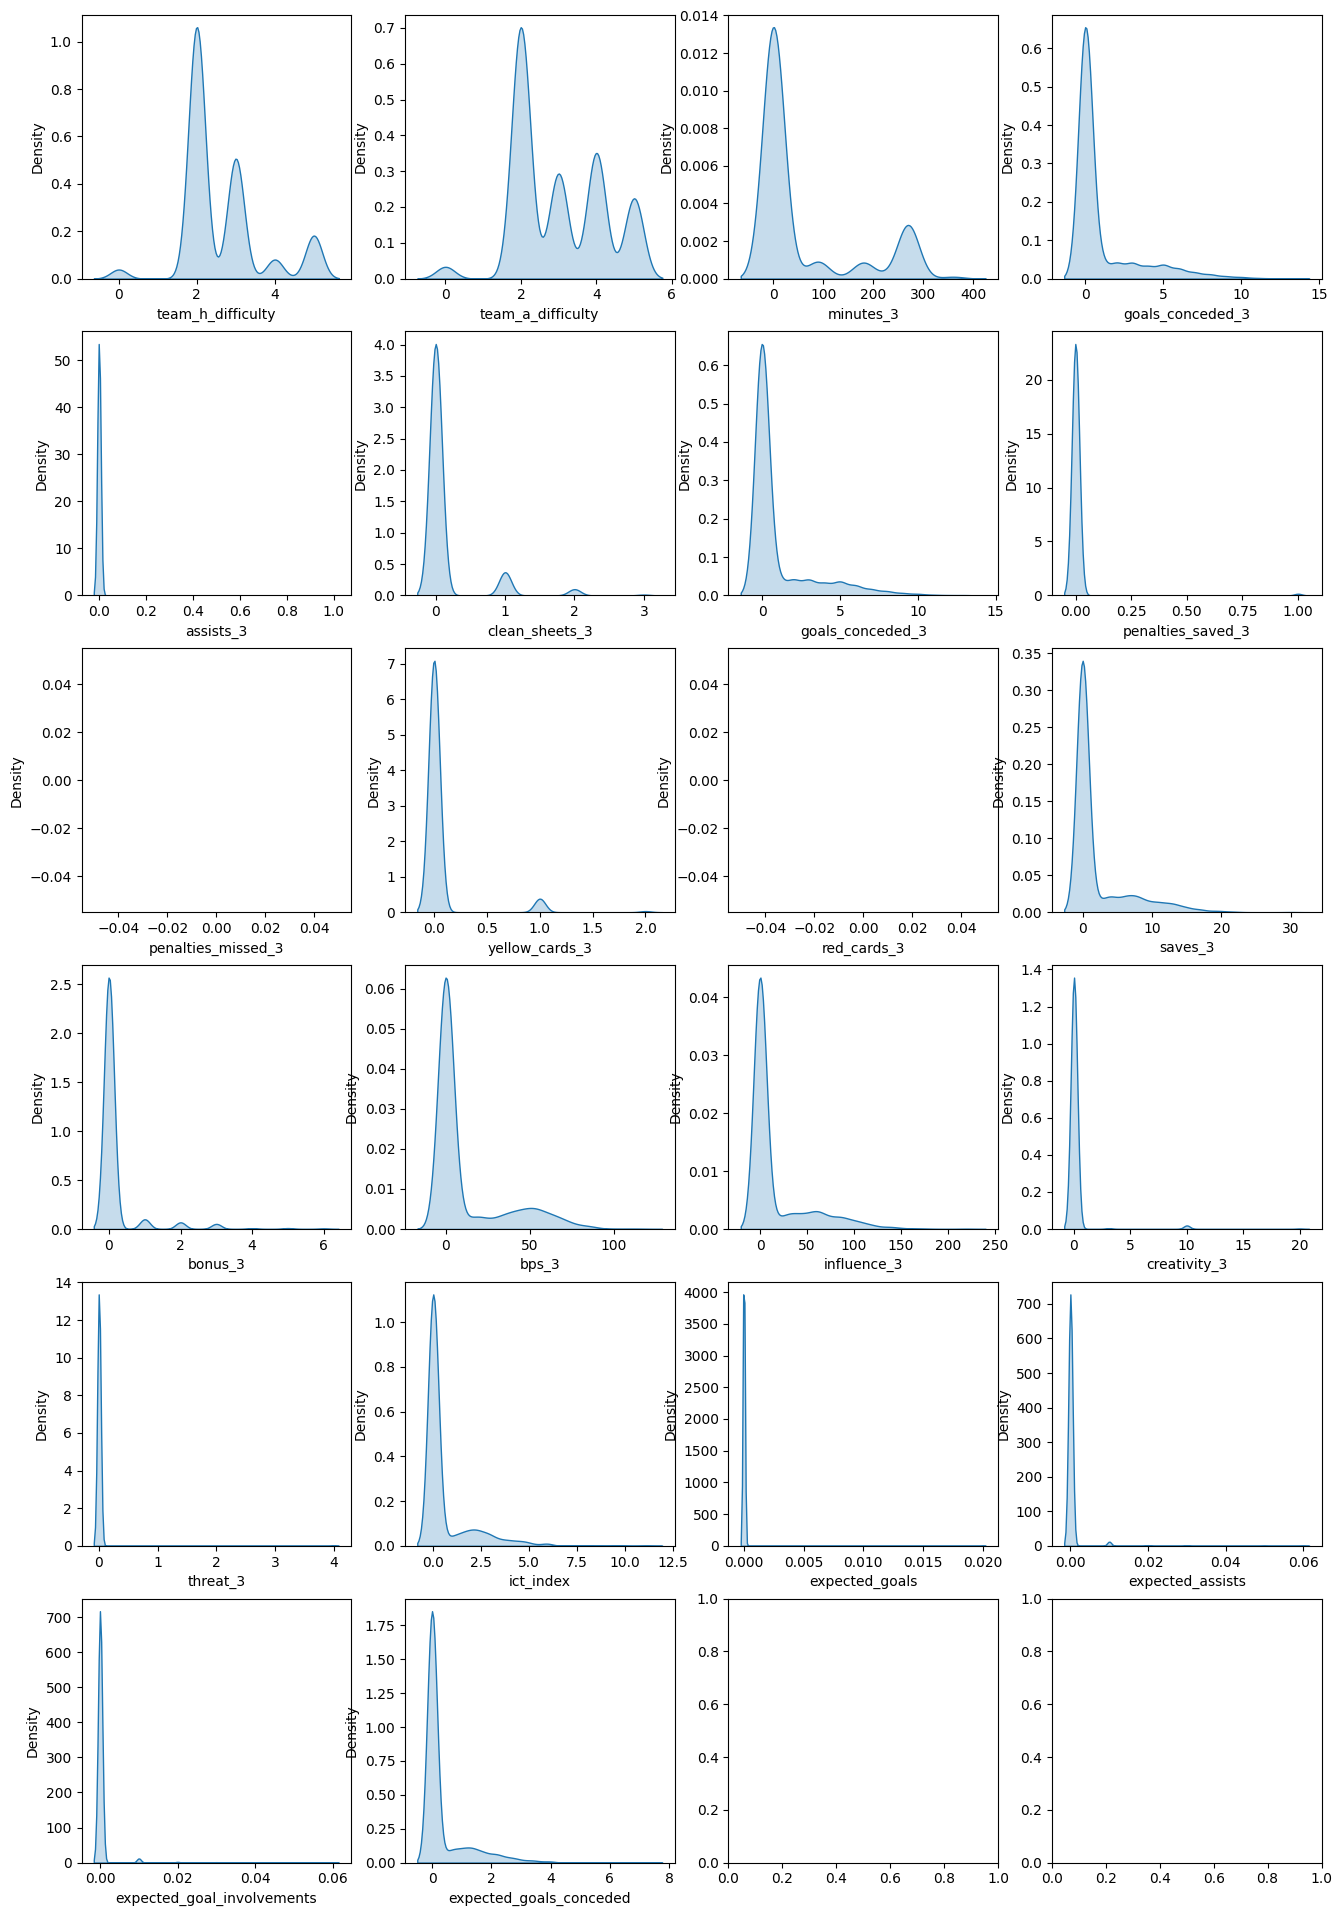

In [20]:
# Plot a comparison
fig, axs = plt.subplots(6, 4, figsize=(16, 24))
sns.kdeplot(df_gk.team_h_difficulty, fill=True, ax=axs[0,0])
sns.kdeplot(df_gk.team_a_difficulty, fill=True, ax=axs[0,1])
sns.kdeplot(df_gk.minutes_3, fill=True, ax=axs[0,2])
sns.kdeplot(df_gk.goals_conceded_3, fill=True, ax=axs[0,3])

sns.kdeplot(df_gk.assists_3, fill=True, ax=axs[1,0])
sns.kdeplot(df_gk.clean_sheets_3, fill=True, ax=axs[1, 1])
sns.kdeplot(df_gk.goals_conceded_3, fill=True, ax=axs[1,2])
sns.kdeplot(df_gk.penalties_saved_3, fill=True, ax=axs[1,3])

sns.kdeplot(df_gk.penalties_missed_3, fill=True, ax=axs[2,0])
sns.kdeplot(df_gk.yellow_cards_3, fill=True, ax=axs[2,1])
sns.kdeplot(df_gk.red_cards_3, fill=True, ax=axs[2,2])
sns.kdeplot(df_gk.saves_3, fill=True, ax=axs[2,3])


sns.kdeplot(df_gk.bonus_3, fill=True, ax=axs[3,0])
sns.kdeplot(df_gk.bps_3, fill=True, ax=axs[3,1])
sns.kdeplot(df_gk.influence_3, fill=True, ax=axs[3,2])
sns.kdeplot(df_gk.creativity_3, fill=True, ax=axs[3,3])

sns.kdeplot(df_gk.threat_3, fill=True, ax=axs[4,0])
sns.kdeplot(df_gk.ict_index, fill=True, ax=axs[4,1])
sns.kdeplot(df_gk.expected_goals, fill=True, ax=axs[4,2])
sns.kdeplot(df_gk.expected_assists, fill=True, ax=axs[4,3])

sns.kdeplot(df_gk.expected_goal_involvements, fill=True, ax=axs[5,0])
sns.kdeplot(df_gk.expected_goals_conceded, fill=True, ax=axs[5,1])

In [21]:
df_gk

,team_h_difficulty,team_a_difficulty,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,starts_3,minutes_3,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
16,2,5,1.3,0.0,0.00,0.00,1.18,2,1.0,90.0,...,0.0,0.0,0.0,0.0,1.0,0.0,10.0,12.6,0.0,0.0
674,5,3,1.5,0.0,0.01,0.01,1.06,6,1.0,90.0,...,0.0,0.0,0.0,0.0,1.0,0.0,10.0,12.6,0.0,0.0
1344,2,5,1.2,0.0,0.00,0.00,0.53,1,2.0,180.0,...,0.0,0.0,0.0,0.0,3.0,0.0,35.0,28.0,0.0,0.0
2029,3,5,1.1,0.0,0.00,0.00,0.96,2,3.0,270.0,...,0.0,0.0,0.0,0.0,4.0,0.0,45.0,40.2,0.0,0.0
2732,5,3,0.0,0.0,0.00,0.00,0.00,0,3.0,270.0,...,0.0,0.0,0.0,0.0,4.0,0.0,45.0,38.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18653,3,3,0.0,0.0,0.00,0.00,0.00,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19476,2,4,0.0,0.0,0.00,0.00,0.00,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20304,3,2,0.0,0.0,0.00,0.00,0.00,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21136,3,4,0.0,0.0,0.00,0.00,0.00,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='total_points', ylabel='Density'>

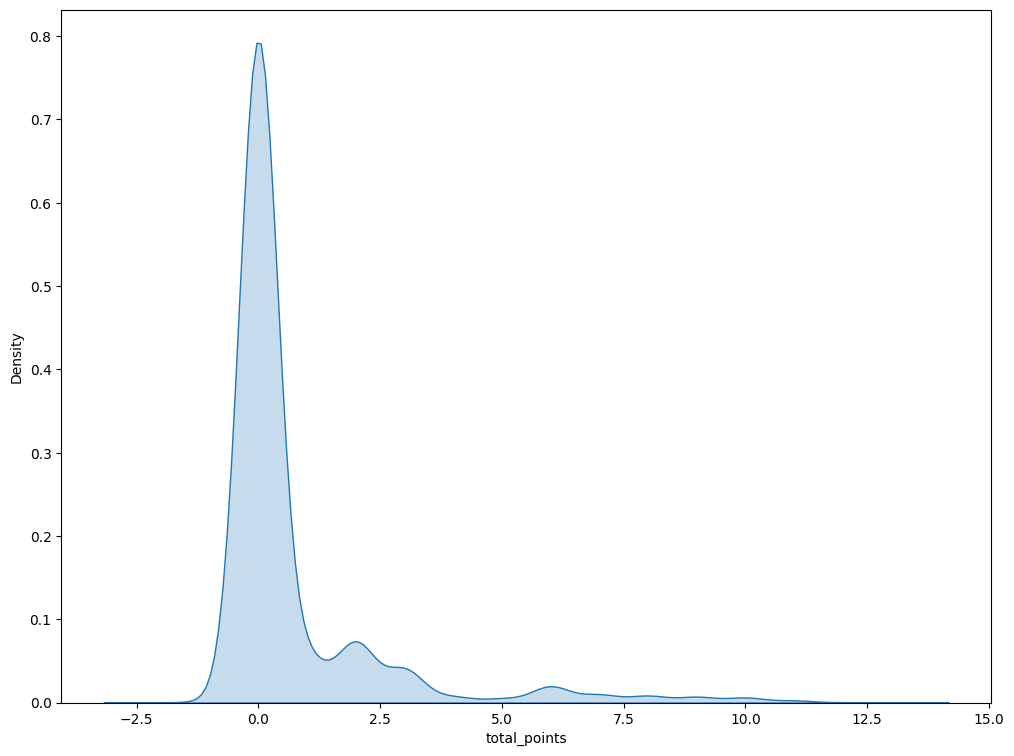

In [22]:
sns.kdeplot(df_gk.total_points, fill=True)

<ipython-input-23-6b8c813133dc>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_data, shade=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='total_points', ylabel='Density'>

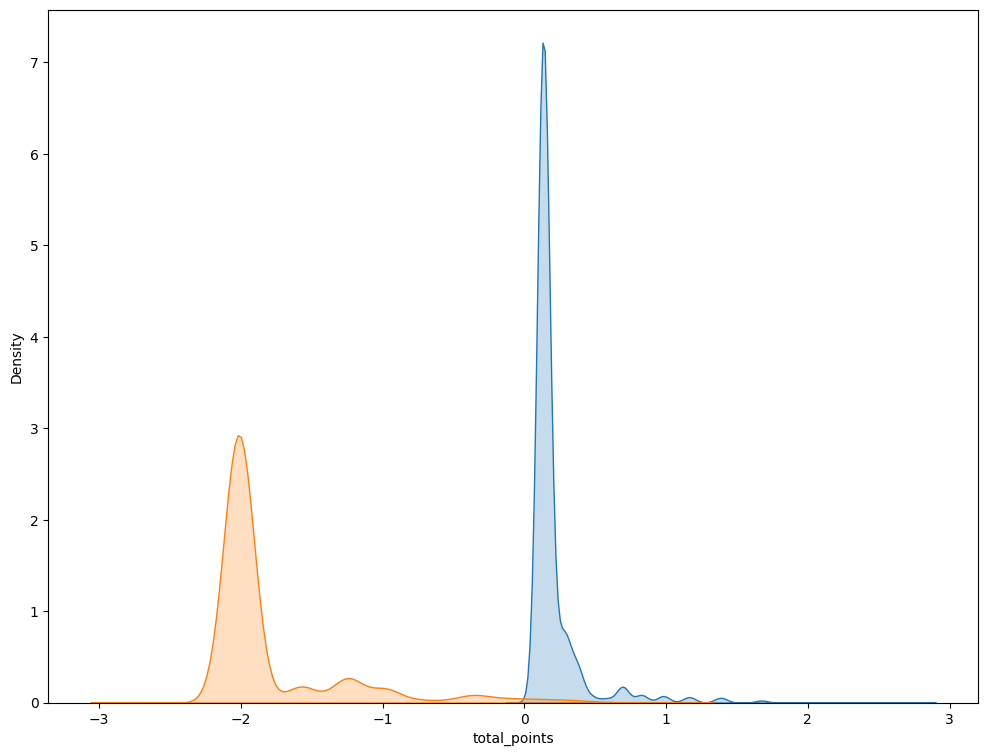

In [23]:
reflected_data = max(df_gk['total_points']) - df_gk['total_points']
log_transformed = np.log1p(reflected_data)
final_data = max(log_transformed) - log_transformed
sns.kdeplot(final_data, shade=True)


sns.kdeplot(np.log(final_data), fill=True)

<Axes: xlabel='log_total_points', ylabel='Density'>

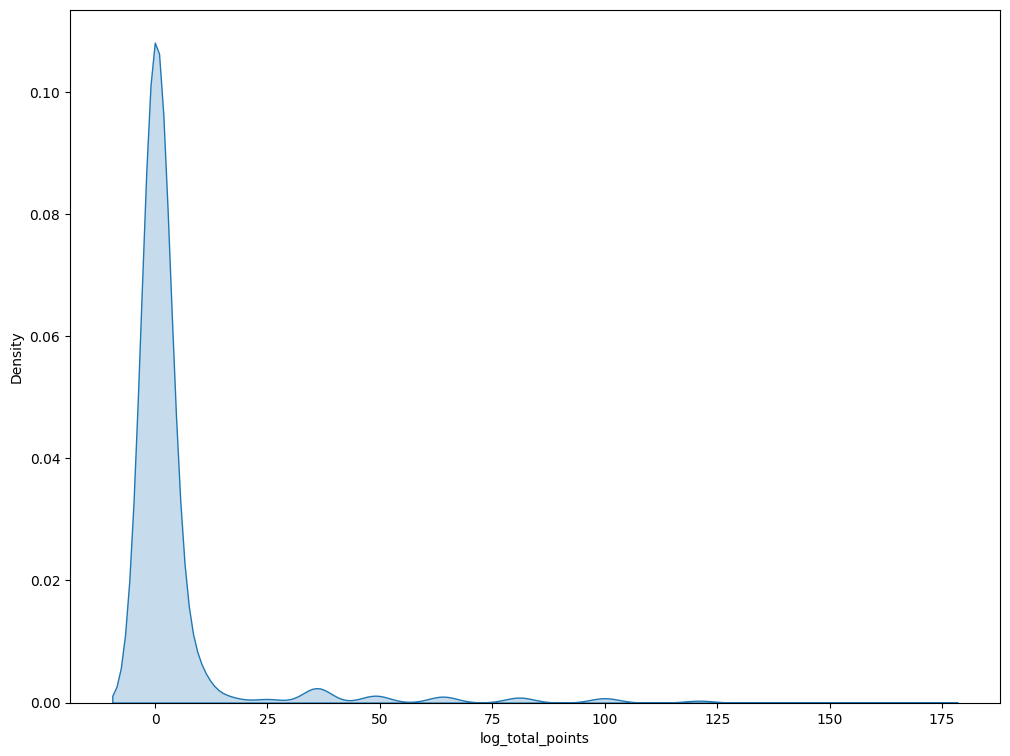

In [24]:
from scipy import stats
# normalize the target
df_gk['log_total_points'] = np.square(df_gk['total_points'])
# df_gk = df_gk.drop('total_points', axis=1)
sns.kdeplot(df_gk.log_total_points, fill=True)

In [25]:
scaler_2 = StandardScaler()
df_gk_scaled = scaler_2.fit_transform(df_gk)

In [26]:

df_gk['log_total_points'] = np.log(df_gk['total_points'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)

gmm.fit(df_gk.log_total_points.values.reshape(-1, 1))

df_gk['target_class'] = gmm.predict(df_gk.log_total_points.values.reshape(-1, 1))

ValueError: Input X contains NaN.
GaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: >

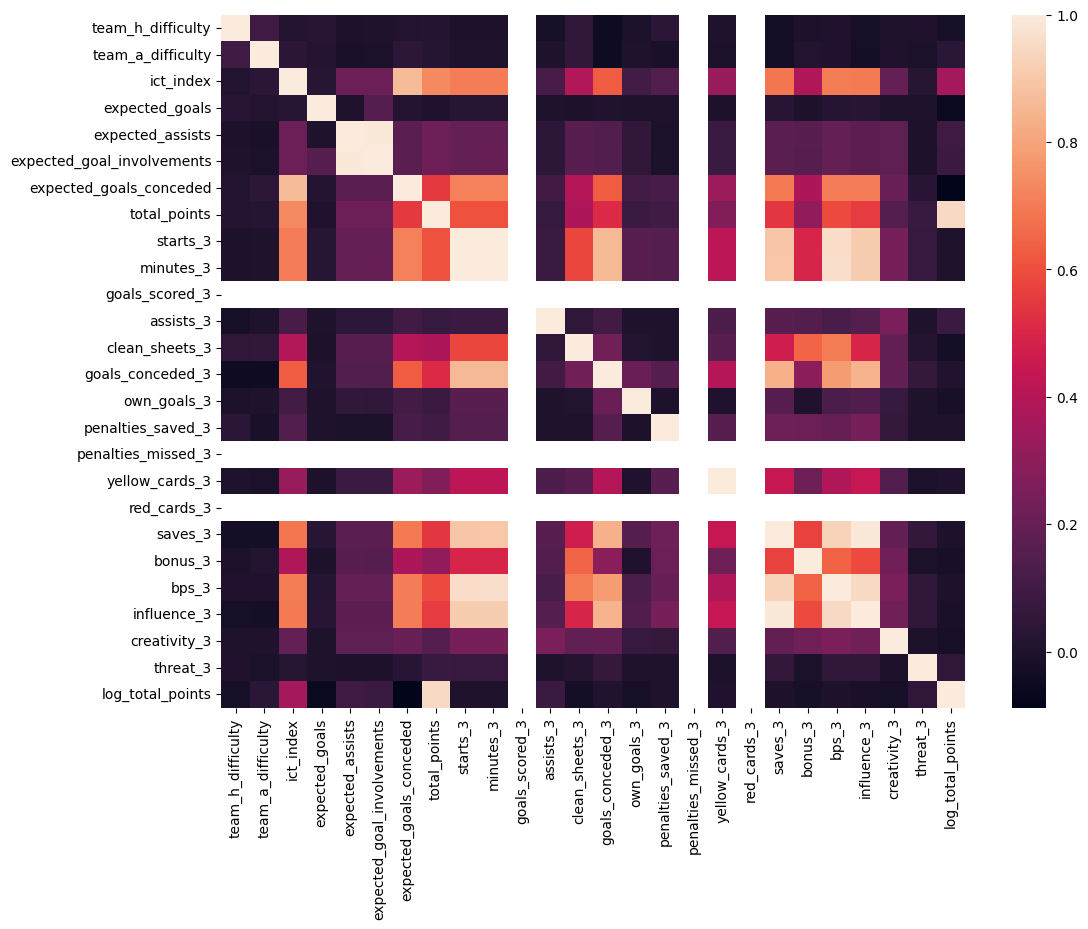

In [28]:
corr_gk = df_gk.corr()
sns.heatmap(corr_gk)

## Train-Test Split

In [33]:
gk_feat = df_gk.drop('log_total_points', axis=1)
gk_target = df_gk['log_total_points']

gk_x_train, gk_x_test,gk_y_train, gk_y_test = train_test_split(gk_feat, gk_target, test_size=0.2)

In [30]:
working_data.sample(10)

,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,starts_3,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
19263,2,4,2,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13153,2,2,2,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20314,5,2,2,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18445,3,5,3,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13417,2,2,3,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18507,3,3,3,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,2.0,11.0,4.0
5669,2,2,3,0.0,0.0,0.0,0.0,0.00,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.8,2.0,6.0
7647,3,4,3,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8349,2,4,4,9.3,0.6,0.0,0.6,2.12,8,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,11.6,23.0
6825,3,3,1,0.0,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
working_data.describe()

,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,starts_3,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
count,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,...,21158.000000,21158.00000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000,21158.000000
mean,2.579922,2.971500,2.574913,1.418872,0.041437,0.025907,0.067335,0.453537,1.077890,0.817799,...,0.000756,0.00104,0.162255,0.006617,0.236459,0.237924,13.541261,17.335013,11.658290,10.949570
std,1.000457,1.176205,0.856283,2.821374,0.151916,0.084831,0.193421,0.817034,2.317658,1.178469,...,0.027490,0.03223,0.426138,0.081077,1.562971,0.801647,21.104060,28.465796,24.408269,24.649547
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,3.000000,1.800000,0.000000,0.010000,0.020000,0.680000,1.000000,2.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,23.000000,27.800000,13.300000,9.000000
max,5.000000,5.000000,4.000000,27.400000,2.770000,1.470000,3.880000,7.820000,23.000000,4.000000,...,1.000000,1.00000,3.000000,1.000000,30.000000,8.000000,155.000000,220.000000,288.000000,281.000000


In [32]:
working_data['log_total_points'].count(), working_data['log_total_points'].isnull().sum()

KeyError: 'log_total_points'

In [ ]:
working_data = working_data.dropna()

In [ ]:
scaler = StandardScaler()
gk_x_train_scaled = scaler.fit_transform(gk_x_train)
gk_x_test_scaled = scaler.transform(gk_x_test)

## Baseline model: Gradient Boosting Classifier with all features

In [ ]:


# Initialize classifier
rfr = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

# Train classifier using all features
rfr.fit(gk_x_train_scaled, gk_y_train)

# Make predictions
preds = rfr.predict(gk_x_test_scaled)

# Evaluate the model using the F1-score
# f1_score_all = round(f1_score(for_tar_test, preds, average='weighted'), 3)

rfr.score(gk_x_test_scaled, gk_y_test)

### Feature selection techniques

#### Variance threshold

In [ ]:
X_train_v1, X_test_v1, y_tain_v1, y_test_v1 = for_ft_train.copy(), for_ft_test.copy(), for_tar_train.copy(), for_tar_test.copy()

In [ ]:
# Calculate the variance of each feature
X_train_v1.var(axis=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

In [ ]:
fig, ax = plt.subplots()

x = gk_feature.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y = value + 0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
sel_X_train_v1 = X_train_v1.drop(['expected_assists', 'expected_goals_conceded'], axis=1) # X_train_v1, X_test_v1, y_tain_v1, y_test_v1
sel_X_test_v1 = X_test_v1.drop(['expected_assists', 'expected_goals_conceded'], axis=1)

rfr.fit(sel_X_train_v1, for_tar_train) # ['threat', 'expected_goals', 'expected_assists', 'expected_goal_involvements']

var_preds = rfr.predict(sel_X_test_v1)


rfr.score(sel_X_test_v1, for_tar_test)

#### K-best features

In [ ]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = for_ft_train.copy(), for_ft_test.copy(), for_tar_train.copy(), for_tar_test.copy()

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

score_list  = []

for k in range(1, 8):
  selector = SelectKBest(mutual_info_regression, k=k)
  selector.fit(X_train_v2, y_train_v2)

  sel_X_train_v2 = selector.transform(X_train_v2)
  sel_X_test_v2 = selector.transform(X_test_v2)

  rfr.fit(sel_X_train_v2, y_train_v2)

  score = round(rfr.score(sel_X_test_v2, y_test_v2 ), 3)

  score_list.append(score)


In [ ]:
fig, ax = plt.subplots()
x = np.arange(1,8)
y = score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 14))
ax.set_xticklabels(np.arange(1, 14), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [ ]:
selector = SelectKBest(mutual_info_regression, k=4)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

In [ ]:
sel_X_train_v1 = X_train_v1.drop(['threat', 'expected_goals', 'expected_assists', 'expected_goal_involvements'], axis=1) # X_train_v1, X_test_v1, y_tain_v1, y_test_v1
sel_X_test_v1 = X_test_v1.drop(['threat', 'expected_goals', 'expected_assists', 'expected_goal_involvements'], axis=1)

rfr.fit(sel_X_train_v1, gk_tar_train)

var_preds = rfr.predict(sel_X_test_v1)


rfr.score(sel_X_test_v1, gk_tar_test)

#### Mutual Information

In [46]:
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(gk_train, gk_tar_train)
mutual_info

array([0.00058504, 0.02046718, 0.54168539, 0.00645758, 0.02790801,
       0.02803868, 0.46703287, 0.31783267, 0.35026355, 0.01222185,
       0.01328444, 0.10028566, 0.26684918, 0.        , 0.        ,
       0.        , 0.05514896, 0.00850709, 0.33328585, 0.07511934,
       0.32922827, 0.34613707, 0.02953007, 0.        ])

In [47]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = gk_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.541685
expected_goals_conceded,0.467033
minutes_3,0.350264
influence_3,0.346137
saves_3,0.333286
bps_3,0.329228
starts_3,0.317833
goals_conceded_3,0.266849
clean_sheets_3,0.100286
bonus_3,0.075119


<Axes: >

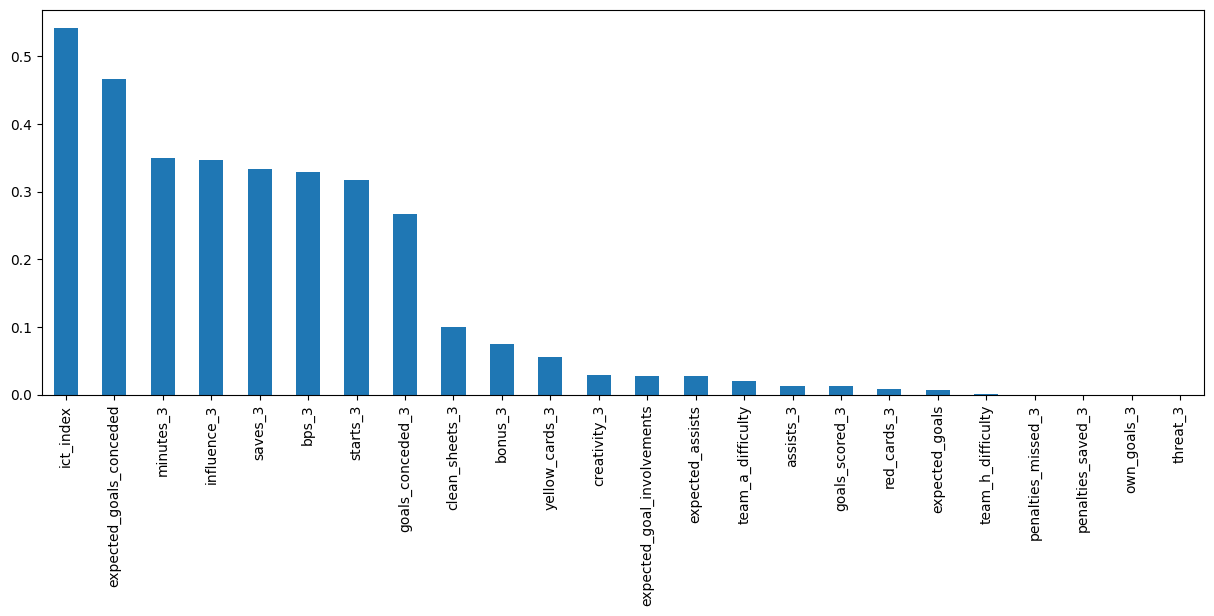

In [48]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [61]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(gk_train, gk_tar_train)

selected_top_columns.get_support()

array([False, False,  True, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False])

In [62]:
gk_20_columns = gk_train.columns[selected_top_columns.get_support()]

gk_20_train = gk_train[gk_20_columns]
gk_20_test = gk_test[gk_20_columns]


##### Model (MI)

##### Linear Model

In [66]:
from sklearn.linear_model import LinearRegression
MI_LR_model = LinearRegression()

MI_LR_model.fit(gk_20_train, gk_tar_train)

MI_LR_preds = MI_LR_model.predict(gk_20_test)

MI_LR_model.score(gk_20_test, gk_tar_test)


# mean_squared_error, root_mean_squared_error mean_absolute_error
mse = mean_squared_error(gk_tar_test, MI_LR_preds)
rmse = mean_squared_error(gk_tar_test, MI_LR_preds, squared=False)
mae = mean_absolute_error(gk_tar_test, MI_LR_preds)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 1.468554003441765
Root Mean Squared Error: 1.2118390996505126
Mean Absolute Error: 0.493448669257784


##### Random Forest

In [63]:
mi_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

mi_rf_model.fit(gk_20_train, gk_tar_train)

base_preds = mi_rf_model.predict(gk_20_test)

mi_rf_model.score(gk_20_test, gk_tar_test)

#mean_squared_error, mean_absolute_error
mse = mean_squared_error(gk_tar_test, base_preds)
rmse =mean_squared_error(gk_tar_test, base_preds, squared=False)
mae = mean_absolute_error(gk_tar_test, base_preds)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 1.4854158996918518
Root Mean Squared Error: 1.2187763944595629
Mean Absolute Error: 0.43375491677757083


# Model selection

# Model training

# Model evaluation